- Code adopted from https://rguigoures.github.io/word2vec_pytorch/
- Relevant implementation: https://github.com/Andras7/word2vec-pytorch

In [10]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

import itertools
import re
import gc
import nltk

from nltk.corpus import stopwords
from tqdm.notebook import tqdm, trange
from scipy import sparse
import numpy as np
import pandas as pd
import pygsp

from sklearn import cluster
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

import torch
from torch import nn, autograd
import torch.optim as optim
import torch.nn.functional as F

from src.graph_regularization import *
from src.word2vec import *

%config Completer.use_jedi = False

dev = 'cuda:0'

In [3]:
sample_probability, word_to_index, index_to_word = pd.read_pickle("./cache/w2v_meta_info.pkl")
vocabulary = set(word_to_index.keys())

In [4]:
%time targ_lst, cont_lst = pd.read_pickle("./cache/context_tuple_list_arxiv.pkl")

CPU times: user 4.8 ms, sys: 10.6 s, total: 10.6 s
Wall time: 11 s


In [5]:
pd.value_counts(index_to_word[cont_lst[targ_lst == word_to_index["graph"]]])[:15]

graph        35021
vertex       16969
edge         12273
number       10956
random       10779
network       9949
problem       9687
set           7987
connected     7300
class         7221
algorithm     7144
based         6576
given         6329
show          6264
complete      6246
dtype: int64

## Basic word2vec

In [40]:
del loss, losses, optimizer, net
gc.collect()
torch.cuda.empty_cache()

In [7]:
net = Word2Vec(embedding_size=25**2, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net.parameters())
batch_size = 25000

losses = []

In [8]:
%%time

p_iter = trange(0, targ_lst.size, batch_size)
for batch_start in p_iter:
    neg_words = np.random.choice(sample_probability.index.values, size=(min(len(targ_lst) - batch_start, batch_size), 5), p=sample_probability.values)
    target_tensor = torch.from_numpy(targ_lst[batch_start:(batch_start + batch_size)]).long().to(dev)
    context_tensor = torch.from_numpy(cont_lst[batch_start:(batch_start + batch_size)]).long().to(dev)
    neg_tensor = torch.from_numpy(neg_words).long().to(dev)

    net.zero_grad()
    loss = net(target_tensor, context_tensor, neg_tensor)
    losses.append(loss.data.item())

    loss.backward()
    optimizer.step()

    p_iter.set_postfix({"loss": np.round(losses[-1])})


CPU times: user 32min 49s, sys: 5min 13s, total: 38min 2s
Wall time: 37min 48s


In [ ]:
# torch.save(net.cpu(), "./models/w2v_arxiv.pkl")
torch.save(net.state_dict(), "./models/w2v_arxiv_state.pth")

In [9]:
net = net.cpu();

activations = []
dict(net.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

In [10]:
activations = []
lookup_table = {k: net.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table = pd.Series(lookup_table)[vocabulary]
emb_mat = np.concatenate(lookup_table.values)

joint_activations = torch.vstack(activations).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'knn')

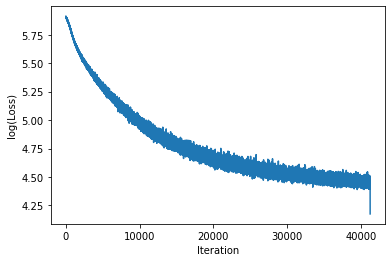

In [27]:
plt.plot(np.log10(losses))
plt.xlabel("Iteration"); plt.ylabel("log(Loss)");

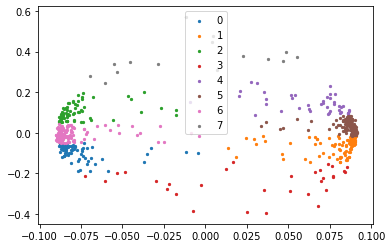

In [11]:
spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

In [12]:
from sklearn.metrics import pairwise

In [14]:
lookup_table.index.values[pairwise.cosine_similarity(emb_mat, lookup_table['paper']).flatten().argsort()[::-1][:10]]

array(['paper', 'article', 'work', 'new', 'aim', 'author', 'purpose',
       'issue', 'introduce', 'address'], dtype=object)

## Graph-regularized (grid)

In [33]:
lap_csr = nx.linalg.normalized_laplacian_matrix(nx.grid_graph((15, 15)))
# coo = sparse.coo_matrix(lap_csr)
# values = coo.data
# indices = np.vstack((coo.row, coo.col))

# lap_torch = torch.sparse.FloatTensor(torch.LongTensor(indices), torch.FloatTensor(values), torch.Size(coo.shape))

lap_torch = torch.Tensor(lap_csr.A)

In [39]:
%%time

net_graph = Word2Vec(embedding_size=225, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net_graph.parameters())
batch_size = 25000

activations = []
dict(net_graph.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

losses = []
graph_losses = []
p_iter = trange(0, targ_lst.size, batch_size)
for batch_start in p_iter:
    neg_words = np.random.choice(sample_probability.index.values, size=(min(len(targ_lst) - batch_start, batch_size), 5), p=sample_probability.values)
    target_tensor, context_tensor, neg_tensor = [torch.from_numpy(x).long().to(dev) for x in (targ_lst[batch_start:(batch_start + batch_size)], cont_lst[batch_start:(batch_start + batch_size)], neg_words)]

    activations = []
    net_graph.zero_grad()
    loss = net_graph(target_tensor, context_tensor, neg_tensor)

    gl = graph_loss(activations[-1], lap_torch) * 10.0
    graph_losses.append(gl.data.item())
    losses.append(loss.data.item())
    loss += gl

    loss.backward()
    optimizer.step()
    p_iter.set_postfix({"loss": np.round(losses[-1]), "graph": np.round(graph_losses[-1])})

  0%|          | 0/41274 [00:00<?, ?it/s]

CPU times: user 5h 45min 14s, sys: 12min 36s, total: 5h 57min 50s
Wall time: 1h 41min 53s


In [87]:
torch.save(net_graph.state_dict(), "./models/w2v_arxiv_graph_state.pth")

In [40]:
import matplotlib.pyplot as plt

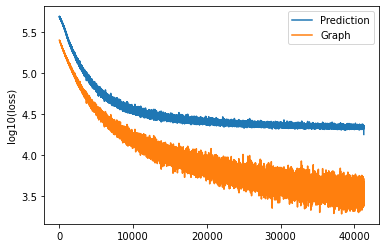

In [41]:
plt.plot(np.log10(losses), label="Prediction")
plt.plot(np.log10(graph_losses), label="Graph")
plt.ylabel("log10(loss)")
plt.legend();

### Evaluation

In [42]:
from sklearn.metrics import pairwise
import seaborn as sns

In [43]:
net_graph = net_graph.cpu();
net = net.cpu();

In [68]:
lookup_table_graph = {k: net_graph.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table_graph = pd.Series(lookup_table_graph)[vocabulary]
lookup_table = {k: net.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table = pd.Series(lookup_table)[vocabulary]

emb_mat_graph = np.concatenate(lookup_table_graph.values)
emb_mat = np.concatenate(lookup_table.values)

  0%|          | 0/107727 [00:00<?, ?it/s]

  0%|          | 0/107727 [00:00<?, ?it/s]

In [31]:
lookup_table.index.values[pairwise.cosine_similarity(emb_mat, lookup_table['paper']).flatten().argsort()[::-1][:5]]

array(['paper', 'article', 'work', 'idea', 'aim'], dtype=object)

In [46]:
lookup_table.index.values[pairwise.cosine_similarity(emb_mat, lookup_table['paper']).flatten().argsort()[::-1][:5]]

array(['paper', 'article', 'work', 'idea', 'concept'], dtype=object)

In [58]:
lookup_table.index.values[pairwise.cosine_similarity(emb_mat, lookup_table['man']).flatten().argsort()[::-1][:5]]

array(['man', 'conflicting', 'geographic', 'inspect', 'abnormal'],
      dtype=object)

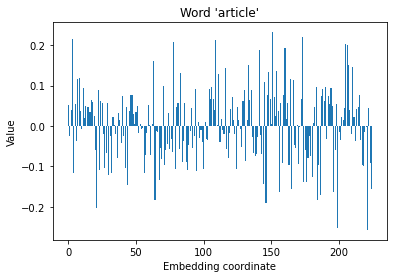

In [77]:
plt.bar(np.arange(225), lookup_table["article"].flatten())
plt.xlabel("Embedding coordinate"); plt.ylabel("Value"); plt.title("Word 'article'");

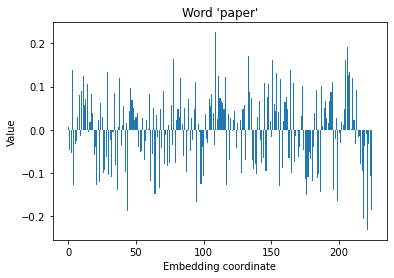

In [78]:
plt.bar(np.arange(225), lookup_table["paper"].flatten())
plt.xlabel("Embedding coordinate"); plt.ylabel("Value"); plt.title("Word 'paper'");

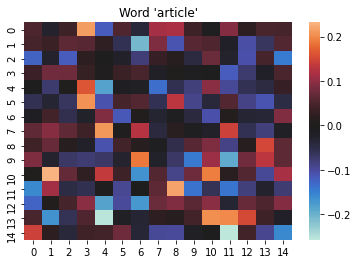

In [79]:
sns.heatmap(lookup_table["article"].reshape(15, 15), center=0);
plt.title("Word 'article'");

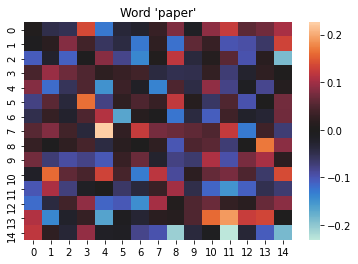

In [80]:
sns.heatmap(lookup_table["paper"].reshape(15, 15), center=0);
plt.title("Word 'paper'");

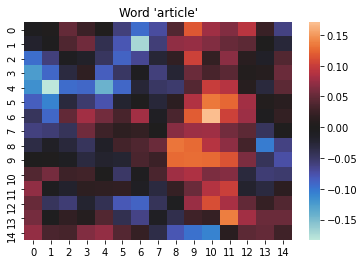

In [84]:
sns.heatmap(lookup_table_graph["article"].reshape(15, 15), center=0)
plt.title("Word 'article'");

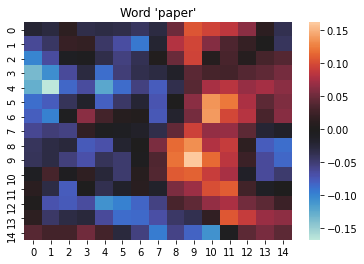

In [86]:
sns.heatmap(lookup_table_graph["paper"].reshape(15, 15), center=0)
plt.title("Word 'paper'");

<AxesSubplot:>

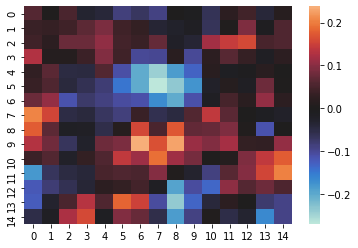

In [65]:
sns.heatmap(lookup_table["neuron"].reshape(15, 15), center=0)

<AxesSubplot:>

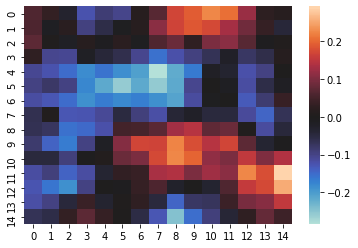

In [67]:
sns.heatmap(lookup_table["neural"].reshape(15, 15), center=0)

## Grap-regularized (k-NN)

In [30]:
del loss, losses, optimizer, net_graph, gl, graph_losses, lap
gc.collect()
torch.cuda.empty_cache()

In [31]:
net_graph = Word2Vec(embedding_size=25**2, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net_graph.parameters())
batch_size = 25000

activations = []
dict(net_graph.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

In [32]:
%%time

lap = None
losses = []
graph_losses = []
p_iter = trange(0, targ_lst.size, batch_size)
for i,batch_start in enumerate(p_iter):
    activations = []
    neg_words = np.random.choice(sample_probability.index.values, size=(min(len(targ_lst) - batch_start, batch_size), 5), p=sample_probability.values)
    target_tensor, context_tensor, neg_tensor = [torch.from_numpy(x).long().to(dev) for x in (targ_lst[batch_start:(batch_start + batch_size)], cont_lst[batch_start:(batch_start + batch_size)], neg_words)]

    net_graph.zero_grad()
    loss = net_graph(target_tensor, context_tensor, neg_tensor)
    
    losses.append(loss.data.item())
    if lap is not None:
        gl = graph_loss(activations[-1], lap) * 200.0
        graph_losses.append(gl.data.item())
        loss += gl

    loss.backward()
    optimizer.step()

    if i > 1 and i % 500 == 0:
        joint_activations = net_graph.embeddings_target(torch.tensor(np.array(list(word_to_index.values())), dtype=torch.long).to(dev)).cpu().detach().numpy()
        adj_mat = create_graph_from_embedding(joint_activations.T, 'knn')
        graph = pygsp.graphs.Graph(adj_mat)
        graph.compute_laplacian(lap_type='normalized')
        lap = torch.Tensor(graph.L.A)

    if len(graph_losses) > 0:
        p_iter.set_postfix({"loss": np.round(losses[-1]), "graph": np.round(graph_losses[-1])})
    else:
        p_iter.set_postfix({"loss": np.round(losses[-1])})


CPU times: user 14h 15min 35s, sys: 1h 36min 56s, total: 15h 52min 31s
Wall time: 2h 14min 43s


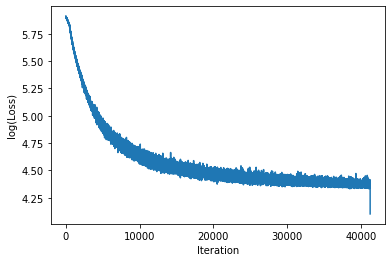

In [33]:
plt.plot(np.log10(losses))
plt.xlabel("Iteration"); plt.ylabel("log(Loss)");

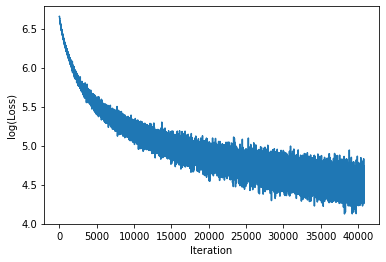

In [34]:
plt.plot(np.log10(graph_losses))
plt.xlabel("Iteration"); plt.ylabel("log(Loss)");

In [35]:
net_graph = net_graph.cpu();

In [36]:
activations = []
lookup_table_graph = {k: net_graph.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table_graph = pd.Series(lookup_table_graph)[vocabulary]
emb_mat_graph = np.concatenate(lookup_table_graph.values)

In [37]:
joint_activations = torch.vstack(activations).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'knn')

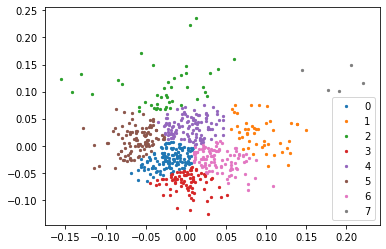

In [38]:
spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

In [41]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, lookup_table_graph['paper']).flatten().argsort()[::-1][:10]]

array(['paper', 'problem', 'setting', 'work', 'develop', 'new', 'context',
       'concept', 'attempt', 'approach'], dtype=object)

## Grap-regularized (k-NN flat)

In [63]:
del loss, losses, optimizer, net_graph, gl, graph_losses, lap
gc.collect()
torch.cuda.empty_cache()

In [64]:
net_graph = Word2Vec(embedding_size=25**2, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net_graph.parameters())
batch_size = 25000

activations = []
dict(net_graph.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

In [65]:
%%time

lap = None
losses = []
graph_losses = []
p_iter = trange(0, targ_lst.size, batch_size)
for i,batch_start in enumerate(p_iter):
    activations = []
    neg_words = np.random.choice(sample_probability.index.values, size=(min(len(targ_lst) - batch_start, batch_size), 5), p=sample_probability.values)
    target_tensor, context_tensor, neg_tensor = [torch.from_numpy(x).long().to(dev) for x in (targ_lst[batch_start:(batch_start + batch_size)], cont_lst[batch_start:(batch_start + batch_size)], neg_words)]

    net_graph.zero_grad()
    loss = net_graph(target_tensor, context_tensor, neg_tensor)

    losses.append(loss.data.item())
    if lap is not None:
        gl = graph_loss(activations[-1], lap) * 200.0
        graph_losses.append(gl.data.item())
        loss += gl

    loss.backward()
    optimizer.step()

    if i > 1 and i % 500 == 0:
        joint_activations = net_graph.embeddings_target(torch.tensor(np.array(list(word_to_index.values())), dtype=torch.long).to(dev)).cpu().detach().numpy()
        adj_mat = create_graph_from_embedding(joint_activations.T, 'knn-flat')
        graph = pygsp.graphs.Graph(adj_mat)
        graph.compute_laplacian(lap_type='normalized')
        lap = torch.Tensor(graph.L.A)

    if len(graph_losses) > 0:
        p_iter.set_postfix({"loss": np.round(losses[-1]), "graph": np.round(graph_losses[-1])})
    else:
        p_iter.set_postfix({"loss": np.round(losses[-1])})


CPU times: user 14h 17min 6s, sys: 1h 23min 57s, total: 15h 41min 3s
Wall time: 2h 12min 27s


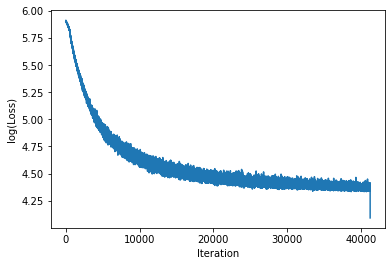

In [66]:
plt.plot(np.log10(losses))
plt.xlabel("Iteration"); plt.ylabel("log(Loss)");

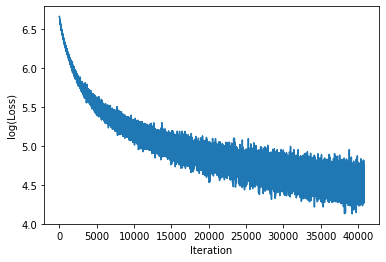

In [67]:
plt.plot(np.log10(graph_losses))
plt.xlabel("Iteration"); plt.ylabel("log(Loss)");

In [68]:
net_graph = net_graph.cpu();

In [69]:
activations = []
lookup_table_graph = {k: net_graph.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table_graph = pd.Series(lookup_table_graph)[vocabulary]
emb_mat_graph = np.concatenate(lookup_table_graph.values)

In [70]:
joint_activations = torch.vstack(activations).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'knn')

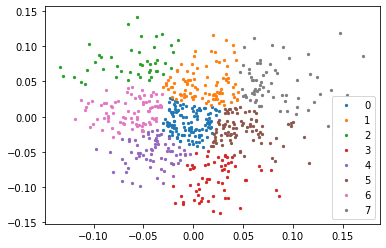

In [71]:
spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

In [72]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, lookup_table_graph['paper']).flatten().argsort()[::-1][:10]]

array(['paper', 'problem', 'setting', 'article', 'new', 'application',
       'tackle', 'develop', 'work', 'purpose'], dtype=object)

## Grap-regularized (full cosine)

In [35]:
del loss, losses, optimizer, net_graph, gl, graph_losses, lap
gc.collect()
torch.cuda.empty_cache()

In [36]:
net_graph = Word2Vec(embedding_size=25**2, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net_graph.parameters())
batch_size = 25000

activations = []
dict(net_graph.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

In [37]:
%%time

lap = None
losses = []
graph_losses = []
p_iter = trange(0, targ_lst.size, batch_size)
for i,batch_start in enumerate(p_iter):
    activations = []
    neg_words = np.random.choice(sample_probability.index.values, size=(min(len(targ_lst) - batch_start, batch_size), 5), p=sample_probability.values)
    target_tensor, context_tensor, neg_tensor = [torch.from_numpy(x).long().to(dev) for x in (targ_lst[batch_start:(batch_start + batch_size)], cont_lst[batch_start:(batch_start + batch_size)], neg_words)]

    net_graph.zero_grad()
    loss = net_graph(target_tensor, context_tensor, neg_tensor)

    losses.append(loss.data.item())
    if lap is not None:
        gl = graph_loss(activations[-1], lap) * 30.0
        graph_losses.append(gl.data.item())
        loss += gl

    loss.backward()
    optimizer.step()

    if i > 1 and i % 500 == 0:
        joint_activations = net_graph.embeddings_target(torch.tensor(np.array(list(word_to_index.values())), dtype=torch.long).to(dev)).cpu().detach().numpy()
        adj_mat = create_graph_from_embedding(joint_activations.T, 'full')
        graph = pygsp.graphs.Graph(adj_mat)
        graph.compute_laplacian(lap_type='normalized')
        lap = torch.Tensor(graph.L.A)

    if len(graph_losses) > 0:
        p_iter.set_postfix({"loss": np.round(losses[-1]), "graph": np.round(graph_losses[-1])})
    else:
        p_iter.set_postfix({"loss": np.round(losses[-1])})


CPU times: user 14h 34min 13s, sys: 1h 43min 3s, total: 16h 17min 17s
Wall time: 2h 20min 39s


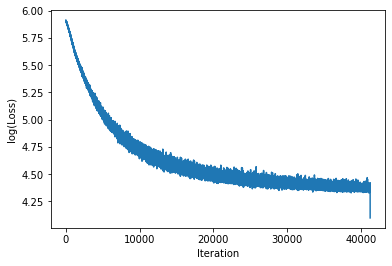

In [38]:
plt.plot(np.log10(losses))
plt.xlabel("Iteration"); plt.ylabel("log(Loss)");

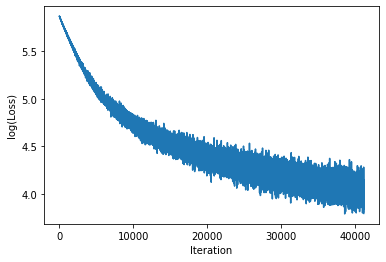

In [39]:
plt.plot(np.log10(graph_losses))
plt.xlabel("Iteration"); plt.ylabel("log(Loss)");

In [40]:
net_graph = net_graph.cpu();

In [41]:
activations = []
lookup_table_graph = {k: net_graph.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table_graph = pd.Series(lookup_table_graph)[vocabulary]
emb_mat_graph = np.concatenate(lookup_table_graph.values)

In [45]:
joint_activations = torch.vstack(activations).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'full')

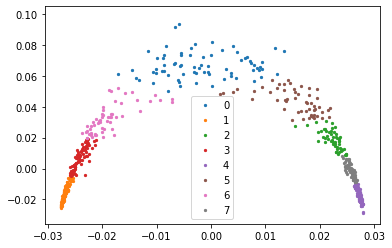

In [46]:
spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

In [44]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, lookup_table_graph['paper']).flatten().argsort()[::-1][:10]]

array(['paper', 'article', 'work', 'aim', 'new', 'problem', 'purpose',
       'proposes', 'concept', 'challenge'], dtype=object)

## Grap-regularized: 8 clusters hclust

In [56]:
del loss, losses, optimizer, net_graph, gl, graph_losses, lap
gc.collect()
torch.cuda.empty_cache()

In [57]:
net_graph = Word2Vec(embedding_size=25**2, vocab_size=len(vocabulary)).to(dev)
optimizer = optim.Adam(net_graph.parameters())
batch_size = 25000

activations = []
dict(net_graph.named_modules())['embeddings_target'].register_forward_hook(lambda mod, inp, out: activations.append(out.cpu()));

In [ ]:
%%time

lap = None
losses = []
graph_losses = []
p_iter = trange(0, targ_lst.size, batch_size)
for i,batch_start in enumerate(p_iter):
    activations = []
    target_tensor, context_tensor, neg_tensor = [x.to(dev) for x in get_next_batch(sample_probability, targ_lst, cont_lst, batch_start=batch_start, batch_size=batch_size)]

    net_graph.zero_grad()
    loss = net_graph(target_tensor, context_tensor, neg_tensor)

    losses.append(loss.data.item())
    if lap is not None:
        gl = graph_loss(activations[-1], lap) * 10.0
        graph_losses.append(gl.data.item())
        loss += gl

    loss.backward()
    optimizer.step()

    if i > 1 and i % 1000 == 0:
        joint_activations = net_graph.embeddings_target(torch.tensor(np.array(list(word_to_index.values())), dtype=torch.long).to(dev)).cpu().detach().numpy()
        lap = create_lap_from_embedding(joint_activations.T, 'hclust', n_clusters=6)

    if len(graph_losses) > 0:
        p_iter.set_postfix({"loss": np.round(losses[-1]), "graph": np.round(graph_losses[-1])})
    else:
        p_iter.set_postfix({"loss": np.round(losses[-1])})

In [ ]:
plt.plot(np.log10(losses), label="Prediction")
plt.plot(np.log10(graph_losses), label="Graph")
plt.xlabel("Iteration"); plt.ylabel("log(Loss)");
plt.legend();

In [40]:
net_graph = net_graph.cpu();

In [41]:
activations = []
lookup_table_graph = {k: net_graph.embeddings_target(torch.tensor([word_to_index[k]], dtype=torch.long)).detach().numpy() for k in tqdm(vocabulary)}
lookup_table_graph = pd.Series(lookup_table_graph)[vocabulary]
emb_mat_graph = np.concatenate(lookup_table_graph.values)

In [45]:
joint_activations = torch.vstack(activations).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'full')

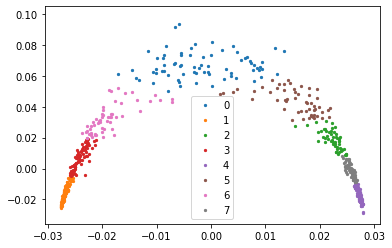

In [46]:
spec_emb = SpectralEmbedding(affinity='precomputed').fit_transform(adj_mat)
clust_labels = cluster.k_means(spec_emb, 8)[1]

for i in set(clust_labels):
    mask = (clust_labels == i)
    plt.scatter(spec_emb[mask,0], spec_emb[mask,1], s=5, label=i)
plt.legend();

In [44]:
lookup_table_graph.index.values[pairwise.cosine_similarity(emb_mat_graph, lookup_table_graph['paper']).flatten().argsort()[::-1][:10]]

array(['paper', 'article', 'work', 'aim', 'new', 'problem', 'purpose',
       'proposes', 'concept', 'challenge'], dtype=object)